## HMM based POS Tagging Assignment


In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, you may use the following hints:

- Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.
- Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?

### Goals

You can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.

 

You need to accomplish the following in this assignment:

- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

In [1]:
# Importing libraries
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import time

In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# Reading the Treebank tagged sentences
tagged_sent = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
tagged_sent[:2]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')]]

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(tagged_sent, test_size = 0.05, random_state = 1000)

print('----Train----\n')
print(len(train_set))
print(train_set[:2])
print('\n----Test----\n')
print(len(test_set))
print(test_set[:2])

----Train----

3718
[[('She', 'PRON'), ('says', 'VERB'), ('0', 'X'), ('she', 'PRON'), ('offered', 'VERB'), ('Mrs.', 'NOUN'), ('Yeargin', 'NOUN'), ('a', 'DET'), ('quiet', 'ADJ'), ('resignation', 'NOUN'), ('and', 'CONJ'), ('thought', 'VERB'), ('0', 'X'), ('she', 'PRON'), ('could', 'VERB'), ('help', 'VERB'), ('*-1', 'X'), ('save', 'VERB'), ('her', 'PRON'), ('teaching', 'NOUN'), ('certificate', 'NOUN'), ('.', '.')], [('Program', 'NOUN'), ('trading', 'NOUN'), ('money', 'NOUN'), ('managers', 'NOUN'), ('have', 'VERB'), ('gained', 'VERB'), ('control', 'NOUN'), ('over', 'ADP'), ('a', 'DET'), ('big', 'ADJ'), ('chunk', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('invested', 'VERB'), ('funds', 'NOUN'), ('in', 'ADP'), ('this', 'DET'), ('country', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('the', 'DET'), ('pressures', 'NOUN'), ('*ICH*-2', 'X'), ('on', 'ADP'), ('such', 'ADJ'), ('money', 'NOUN'), ('managers', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('produce', 'VERB'), ('consistent', 'ADJ'), ('profits', 'NOUN'),

In [5]:
# Creating list of train and test tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print('Train tagged words count: ' + str(len(train_tagged_words)))
print('Test tagged words count: ' + str(len(test_tagged_words)))

Train tagged words count: 95414
Test tagged words count: 5262


In [6]:
# Tokens in the train set
train_tagged_tokens = [tag[0] for tag in train_tagged_words]
train_tagged_tokens[:10]

['She',
 'says',
 '0',
 'she',
 'offered',
 'Mrs.',
 'Yeargin',
 'a',
 'quiet',
 'resignation']

In [7]:
# POS tags for the tokens in the train set

train_tagged_pos_tokens = [tag[1] for tag in train_tagged_words]
train_tagged_pos_tokens[:10]

['PRON', 'VERB', 'X', 'PRON', 'VERB', 'NOUN', 'NOUN', 'DET', 'ADJ', 'NOUN']

In [8]:
# Building the train vocabulary to a set
training_vocabulary_set = set(train_tagged_tokens)

In [9]:
# Building the POS tags to a set
training_pos_tag_set = set(train_tagged_pos_tokens)

In [10]:
# Checking how many unique tags are present in training data
print(len(training_pos_tag_set))

12


In [11]:
# Printing unique tags present in training data
print(training_pos_tag_set)

{'VERB', 'X', 'NUM', 'NOUN', 'DET', 'PRON', 'ADJ', 'ADP', 'PRT', 'CONJ', 'ADV', '.'}


In [12]:
# Checking how many words are present in vocabulary
vocab = {word for word,tag in train_tagged_words}
print(len(vocab))

12032


## Building Model

**Function to compute emission probabilties for a given word**



In [13]:
# Computing emission probability for a given word for a given tag
def word_given_tag(word, tag, train_bag = train_tagged_words):
    taglist = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(taglist)    
    w_in_tag = [pair[0] for pair in taglist if pair[0]==word]    
    word_count_given_tag = len(w_in_tag)    
    
    return (word_count_given_tag, tag_count)

**Function to compute transition probabilties for a given tag and previous tag**

In [14]:
# Computing transition probabilities of a previous and next tag
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    
    t1_tags = [tag for tag in tags if tag == t1]
    
    count_of_t1 = len(t1_tags)
    
    t2_given_t1 = [tags[index+1] for index in range(len(tags) - 1) if tags[index] == t1 and tags[index+1] == t2]
    
    count_t2_given_t1 = len(t2_given_t1)
    
    return(count_t2_given_t1, count_of_t1)

In [15]:
# Checking for NOUN given ADV
t2_given_t1('NOUN','ADV')

(99, 3007)

In [16]:
# Creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(training_pos_tag_set), len(training_pos_tag_set)), dtype = 'float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0] / t2_given_t1(t2, t1)[1]

In [17]:
# Converting the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))

In [18]:
tags_df

,VERB,X,NUM,NOUN,DET,PRON,ADJ,ADP,PRT,CONJ,ADV,.
VERB,0.168742,0.217388,0.023272,0.111146,0.134729,0.035025,0.064679,0.092310,0.031367,0.005526,0.081102,0.034714
X,0.204883,0.074836,0.002713,0.062390,0.054572,0.055689,0.016435,0.144567,0.184937,0.010372,0.024573,0.164034
NUM,0.017272,0.212031,0.184634,0.352591,0.003276,0.001489,0.034247,0.034842,0.026206,0.013996,0.002978,0.116438
NOUN,0.146341,0.029217,0.009507,0.263649,0.012908,0.004388,0.012396,0.177350,0.044246,0.042491,0.017296,0.240209
DET,0.039966,0.045658,0.022042,0.637520,0.005329,0.003754,0.205038,0.009325,0.000242,0.000484,0.012716,0.017924
PRON,0.486883,0.090664,0.007330,0.212191,0.008873,0.008102,0.073302,0.022762,0.011188,0.004630,0.034722,0.039352
ADJ,0.011513,0.020888,0.020724,0.699342,0.004605,0.000658,0.067105,0.077303,0.010691,0.017105,0.004605,0.065461
ADP,0.008329,0.035558,0.062467,0.320128,0.324399,0.069407,0.107848,0.016765,0.001388,0.000961,0.013134,0.039616
PRT,0.399149,0.013425,0.057302,0.249509,0.099869,0.018664,0.084807,0.020301,0.001965,0.002292,0.009496,0.043222
CONJ,0.159366,0.008388,0.041007,0.346692,0.116962,0.059180,0.117428,0.053122,0.005126,0.000466,0.054986,0.037279


**Exploratory Data Analysis (EDA)**

In [19]:
# Importing libraries for heatmap
import matplotlib.pyplot as plt
import seaborn as sns

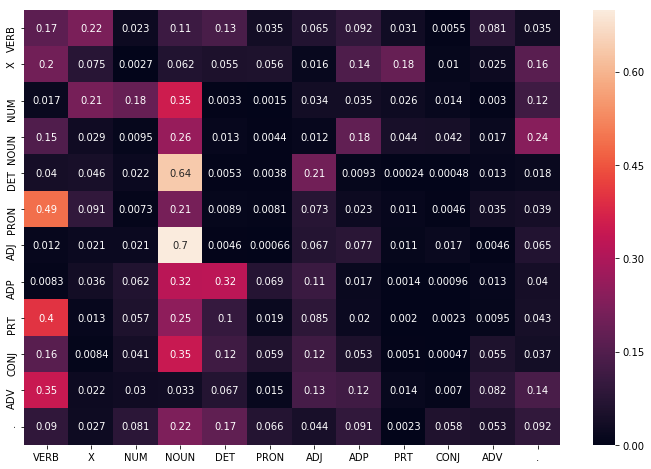

In [20]:
# Heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(12, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

**Vanilla Viterbi Algorithm**

The steps are as follows:

1. Given a sequence of words.
2. Iterate through the sequence.
3. For each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
4. Assign the tag which has maximum probability obtained in step 3 above.
5. Move to the next word in sequence to repeat steps 3 and 4 above.

In [21]:
# Vanilla Viterbi Algorithm
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [22]:
# Testing our Vanilla Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# Choosing random 5 sents
rndom = [random.randint(1, len(test_set)) for x in range(5)]

# List of sents
test_run = [test_set[i] for i in rndom]

# List of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# List of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [23]:
# Tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# Checking Accuracy
vanilla_viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(vanilla_viterbi_word_check) / len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy: ', vanilla_viterbi_accuracy)

Time taken in seconds:  20.266857147216797
Vanilla Viterbi Algorithm Accuracy:  93.10344827586206


In [24]:
# Checking the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('Claude', 'VERB'), ('Claude', 'NOUN')),
 (('weird', 'VERB'), ('weird', 'ADJ')),
 (('Story', 'VERB'), ('Story', 'NOUN')),
 (('Women', 'VERB'), ('Women', 'NOUN')),
 (('more', 'ADV'), ('more', 'ADJ')),
 (('ECONOMIC', 'VERB'), ('ECONOMIC', 'ADJ')),
 (('GROWTH', 'VERB'), ('GROWTH', 'NOUN')),
 (('off', 'PRT'), ('off', 'ADP'))]

In [25]:
# Checking for unknown words 

test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - vocab)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 7


Unknown Words : ['Women', 'GROWTH', 'ECONOMIC', 'Claude', 'weird', 'APPEARS', 'Story']


We see that the incorrectly marked words are mostly not there in the corpus or in other words are unknown words. So, the alogrithm marked them with the tag that occured first ie. VERB. Here, the algorithm is not using any type of justification or basis to tag the words.

**Vanilla Viterbi Modification - 1**

On observing that we see that the emission probability becomes zero in case of unknown words. What we can do here, is to consider only the transmission probablity in such a situation 

In [26]:
# Using transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_for_Unknown_Words_with_Transmission_Prob(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [27]:
# Tagging the test sentences
start = time.time()
tagged_seq = Viterbi_for_Unknown_Words_with_Transmission_Prob(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# Checking Accuracy
vanilla_viterbi_mod_1_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_mod_1_accuracy = len(vanilla_viterbi_mod_1_word_check) / len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy with Modification for Unknown Words using Transmission Probability: ', vanilla_viterbi_mod_1_accuracy)

Time taken in seconds:  22.850938320159912
Vanilla Viterbi Algorithm Accuracy with Modification for Unknown Words using Transmission Probability:  94.82758620689656


**Adding Tag occurance probability weights:** We will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

In [28]:
# Creating a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in training_pos_tag_set:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('VERB', 0.1346552916762739),
 ('X', 0.06568218500429707),
 ('NUM', 0.03519399668811705),
 ('NOUN', 0.28661412371350115),
 ('DET', 0.0865386630892741),
 ('PRON', 0.027165824721738948),
 ('ADJ', 0.06372230490284445),
 ('ADP', 0.09815121470643721),
 ('PRT', 0.032007881442974825),
 ('CONJ', 0.022491458276563188),
 ('ADV', 0.03151529125704823),
 ('.', 0.11626176452092984)]

In [29]:
# Using transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_for_Unknown_Words_with_Transmission_Weighted_Prob(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [30]:
# Tagging the test sentences
start = time.time()
tagged_seq = Viterbi_for_Unknown_Words_with_Transmission_Weighted_Prob(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# Checking Accuracy
vanilla_viterbi_mod_1_word_weighted_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_mod_1_weighted_accuracy = len(vanilla_viterbi_mod_1_word_weighted_check) / len(tagged_seq) * 100
print('Vanilla Viterbi Algorithm Accuracy with Modification for Unknown Words using Transmission Probability with weights: ', vanilla_viterbi_mod_1_weighted_accuracy)

Time taken in seconds:  18.893479824066162
Vanilla Viterbi Algorithm Accuracy with Modification for Unknown Words using Transmission Probability with weights:  95.6896551724138


We can see that using transmission probablity gives us flexibility and generalizibility in terms of words which are not present in the training corpus.

**Vanilla Viterbi Modification - 2**

Here we will explore the n-gram tagging approach to see if we are able to get a better accuracy in terms of the data in hand

In [31]:
# Unigram tagger

unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.8962371721778791


In [32]:
# Bigram tagger

bigram_tagger = nltk.BigramTagger(train_set, backoff = unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed by unigram tagger is -", accuracy_bigram_tagger)

The accuracy of the Bigram Tagger backed by unigram tagger is - 0.8998479665526415


In [33]:
# Trigram tagger

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger backed by unigram tagger is -", accuracy_trigram_tagger)

The accuracy of the Bigram Tagger backed by unigram tagger is - 0.8985176738882554


Now that we have seen the performances of a simple unigram, bigram and trigram tagger, we will try to implement a Viterbi tagger along with a Trigram Tagger backed by a rule based tagger for the scenario of unknown words.

In [34]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [35]:
# Viterbi with handling for unknown words from regex tagger

def Viterbi_Trigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in training_vocabulary_set:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [36]:
# Tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Trigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# Accuracy
viterbi_trigram_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(tagged_seq) * 100
print('Modified Viterbi Trigram Tagger Accuracy: ', viterbi_trigram_accuracy)

Time taken in seconds:  43.93954634666443
Modified Viterbi Trigram Tagger Accuracy:  95.6896551724138


**Comparing the tagging accuracy of the different algorithms used for tagging**

In [37]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                  ['Optimized Vanilla Viterbi', vanilla_viterbi_mod_1_accuracy],
                  ['Optimized Vanilla Viterbi with weights', vanilla_viterbi_mod_1_weighted_accuracy],
                  ['Unigram Tagger', accuracy_unigram_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger * 100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger * 100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,93.103448
Optimized Vanilla Viterbi,94.827586
Optimized Vanilla Viterbi with weights,95.689655
Unigram Tagger,89.623717
Bigram Tagger + Unigram_tagger,89.984797
Trigram Tagger + Bigram_tagger,89.851767
Viterbi + Trigram_tagger,95.689655


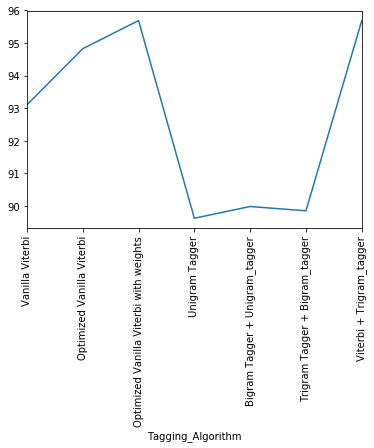

In [39]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

**List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications**

In [40]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [41]:
## Testing
sentence_test_1 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test_1)
tagged_seq = Viterbi(words)
print(tagged_seq)
print('----------------------------------------------------------------------------------------------------')
tagged_seq_mod = Viterbi_Trigram_Tagger(words)
print(tagged_seq_mod)

[('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]
----------------------------------------------------------------------------------------------------
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


In [42]:
sentence_test_2 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words = word_tokenize(sentence_test_2)
tagged_seq = Viterbi(words)
print(tagged_seq)
print('----------------------------------------------------------------------------------------------------')
tagged_seq_mod = Viterbi_Trigram_Tagger(words)
print(tagged_seq_mod)

[('NASA', 'VERB'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'VERB'), ('Satellite', 'VERB'), ('.', '.')]
----------------------------------------------------------------------------------------------------
[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]


In [43]:
sentence_test_3 = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test_3)
tagged_seq = Viterbi(words)
print(tagged_seq)
print('----------------------------------------------------------------------------------------------------')
tagged_seq_mod = Viterbi_Trigram_Tagger(words)
print(tagged_seq_mod)

[('Android', 'VERB'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'VERB'), ('.', '.')]
----------------------------------------------------------------------------------------------------
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


We can see from the above three examples that the ones misclassified by Vanilla Viterbi tagger due to not being present in the training corpus has now been tagged properly with the Viterbi + Trigram tagger with a fallback rule based Regex tagger